In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import scipy.stats as stats

In [2]:
#Connect to database
con = sqlite3.connect("/Users/rena/desktop/class/CA-Collision-History/src/switrs.sqlite")



In [3]:
#Run query that contains only automobile collisions, filter out nonauto collisions
query = '''SELECT Collision_Date FROM collisions
           WHERE Collision_Date IS NOT NULL
           
            AND Bicycle_Collision IS NOT 1
            AND Motorcycle_Collision IS NOT 1
            AND Pedestrian_Collision IS NOT 1
            AND Truck_Collision IS NOT 1
    '''

car_crashes = pd.read_sql_query(query, con)




In [4]:
car_crashes.head()


,collision_date
0,2020-03-14
1,2020-07-26
2,2008-01-07
3,2008-01-04
4,2008-01-04


In [5]:
#Add years column and convert date to years
car_crashes['years'] = pd.DatetimeIndex(car_crashes['collision_date']).year

car_crashes

#out of 9.17M crashes, 7.85M of them are car accidents(86%)



,collision_date,years
0,2020-03-14,2020
1,2020-07-26,2020
2,2008-01-07,2008
3,2008-01-04,2008
4,2008-01-04,2008
...,...,...
7858450,2016-06-12,2016
7858451,2016-05-11,2016
7858452,2016-08-15,2016
7858453,2016-08-18,2016


In [6]:
#Groupby the years and count total collisions within that year
car_crashes_per_year = car_crashes.groupby('years').count()

car_crashes_per_year.head()



,collision_date
years,
2001,450038
2002,472783
2003,467003
2004,468322
2005,464738


In [7]:
#Normalize collisions by CA population for each year from 2001-2020 and add a column for the normalized collisions
car_crashes_per_year['ca_pop'] = [34.49, 34.49, 34.88, 35.25, 35.56, 35.98, 36.23, 36.58,36.96,37.32,37.64, 37.95, 38.26, 38.6,38.92, 39.17,39.36, 39.46, 39.51, 39.78]

car_crashes_per_year['per 1000 rate crashes'] = car_crashes_per_year['collision_date']/car_crashes_per_year['ca_pop']
car_crashes_per_year['per 1000 rate crashes'] =(car_crashes_per_year['per 1000 rate crashes'] /1000000)*1000

car_crashes_per_year.head()

,collision_date,ca_pop,per 1000 rate crashes
years,,,
2001,450038,34.49,13.048362
2002,472783,34.49,13.707828
2003,467003,34.88,13.388847
2004,468322,35.25,13.285730
2005,464738,35.56,13.069123


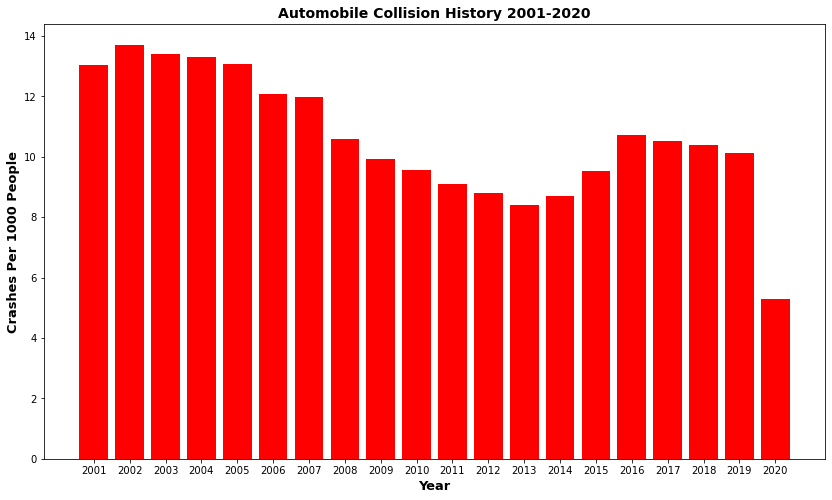

In [64]:
#Plot crashes per 1000 people for 2001-2020 years
plt.figure(figsize=(14, 8))
x = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019','2020']
plt.bar(x, height =car_crashes_per_year['per 1000 rate crashes'], color = 'red')


plt.xlabel("Year", fontsize = 13, fontweight="bold")
plt.ylabel("Crashes Per 1000 People", fontsize = 13, fontweight="bold")
plt.title("Automobile Collision History 2001-2020",fontweight="bold", fontsize = 14)

#CA POP taken from: https://www.statista.com/statistics/206097/resident-population-in-california/
plt.savefig('collision_history.png')

In [9]:
#Add unemployement rate % from 2001 to 2020
car_crashes_per_year['ca_unemp_rate'] = [5.4, 6.7, 6.8, 6.2, 5.4, 4.9, 5.4, 7.3, 11.1, 12.2, 11.7, 10.4, 8.9, 7.5, 6.2, 5.5, 4.8, 4.3, 4.1, 10.7]
#unemp data taken from https://fred.stlouisfed.org/series/CAUR


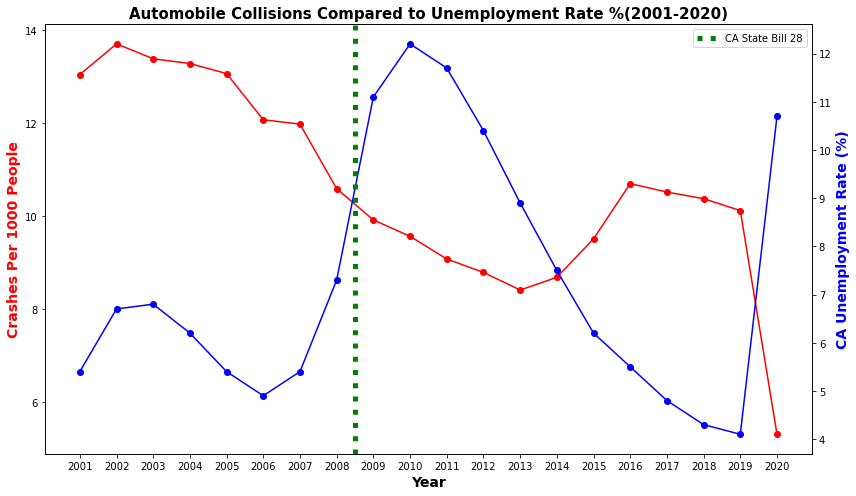

<Figure size 432x288 with 0 Axes>

In [70]:
# Plot crashes on left y axis and unemployment rate on right y axis for 2001-2020
fig,ax = plt.subplots(figsize = (12,7))

#define x = year
x = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019','2020']
# make a plot
ax.plot(x, car_crashes_per_year['per 1000 rate crashes'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Year",fontsize=14)
# set y-axis label
ax.set_ylabel("Crash Rate",color="red",fontsize=14)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(x, car_crashes_per_year['ca_unemp_rate'], color="blue",marker="o")
ax2.set_ylabel("CA Unemployment Rate (%)",color="blue",fontsize=14, fontweight="bold")


# only one line may be specified; full height

plt.axvline(x=7.5, color='g',ls=':', lw=5,label='CA State Bill 28')
plt.legend(bbox_to_anchor=(1.0, 1), loc='best')


ax.set_xlabel('Year', fontweight="bold", fontsize = 14)
ax.set_ylabel('Crashes Per 1000 People', fontweight="bold", fontsize = 14)
plt.title("Automobile Collisions Compared to Unemployment Rate %(2001-2020)",fontweight="bold", fontsize=15)

#ax2.grid(None)

plt.tight_layout()

plt.show()
# save the plot as a file
#fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
 #           format='jpeg',
  #          dpi=100,
   #         bbox_inches='tight')



Looking at this chart,exaggerated due to different axis #s. We can see that from 2001-2006 there was a slight positive correlation between crash rates and umep rate. As crash rates went up so did unemp rate and as the unemp rate went down steeply from 2003 to 2006, crash rates went down steadily. The real correlation is from 2006 to 2020 where there is an inverse relationship between crash rate and unemp rate.



In [11]:
#Calculate Pearson R for crashes compared to unemployment rate
correlation = stats.pearsonr(car_crashes_per_year['per 1000 rate crashes'], car_crashes_per_year['ca_unemp_rate'])
print(correlation)

#There is a moderately negative or inverse correlation between unemployment rate and crash rates for 2001-2020.



(-0.5692413732289785, 0.00880272172618505)


Unemp rate went up during 2007-2010 due to the Great Recession(Dec 2007 to June 2009), which was the worst and longest lasting financial crisis in the United States since the 1929 Depression.
--when people are unemp they are more likely to stay at home. The subprime mortgage crisis was the trigger.

Other possible factors that I would dig deeper into given the time:

#References: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4001674/
California State Bill 28 "specifically bans the use of an electronic wireless communications device to write, send, or read a text-based communication while driving a motor vehicle."

Car safety control regulations
Work from home
Smarter cars - sensor 

cell phone use and traffic related deaths 

driver distraction related accidents - weather

There are many other factors that may have contributed to crashes going down, such as CA vehicle safety stanards, 
carpool rates for CA

-possible reasons could be safer vehicles, safety standard for vehicle much higher than previously, standards for child 
safety; carpooling was big in the 2000s



In [12]:
#Run query on victims killed for automobile collisions from 2001 to 2020
query = '''SELECT killed_victims, Collision_Date FROM collisions
           WHERE killed_victims IS NOT 0 AND
           Collision_Date IS NOT NULL
           
            AND Bicycle_Collision IS NOT 1
            AND Motorcycle_Collision IS NOT 1
            AND Pedestrian_Collision IS NOT 1
            AND Truck_Collision IS NOT 1
    '''

killed_victims = pd.read_sql_query(query, con)




In [13]:
killed_victims


,killed_victims,collision_date
0,1.0,2008-01-04
1,1.0,2008-01-01
2,1.0,2008-01-05
3,1.0,2008-01-04
4,1.0,2008-01-01
...,...,...
35380,1.0,2001-10-31
35381,1.0,2001-12-08
35382,1.0,2016-09-17
35383,1.0,2015-12-06


In [14]:
#Add years column and convert date to years
killed_victims
killed_victims['num_years'] = pd.DatetimeIndex(killed_victims['collision_date']).year
killed_victims = killed_victims.groupby('num_years').count()


In [15]:
killed_victims.sum()


killed_victims    33650
collision_date    35385
dtype: int64

In [16]:
#add CA population for last 20 years to normalize victims killed per pop
killed_victims['ca_pop'] = [34.49, 34.49, 34.88, 35.25, 35.56, 35.98, 36.23, 36.58,36.96,37.32,37.64, 37.95, 38.26, 38.6,38.92, 39.17,39.36, 39.46, 39.51, 39.78]
killed_victims

,killed_victims,collision_date,ca_pop
num_years,,,
2001,2107,2107,34.49
2002,2256,3304,34.49
2003,2256,2943,34.88
2004,2256,2256,35.25
2005,2265,2265,35.56
2006,2099,2099,35.98
2007,2066,2066,36.23
2008,1632,1632,36.58
2009,1538,1538,36.96


In [17]:
#normalize data to victims killed per 1000 people
killed_victims['ca_pop'] = [34.49, 34.49, 34.88, 35.25, 35.56, 35.98, 36.23, 36.58,36.96,37.32,37.64, 37.95, 38.26, 38.6,38.92, 39.17,39.36, 39.46, 39.51, 39.78]
killed_victims['total'] = killed_victims['collision_date']/car_crashes_per_year['ca_pop']
killed_victims['total_killed_victims']  =(killed_victims['total']  /100000) *(1000)



In [18]:
killed_victims



,killed_victims,collision_date,ca_pop,total,total_killed_victims
num_years,,,,,
2001,2107,2107,34.49,61.090171,0.610902
2002,2256,3304,34.49,95.795883,0.957959
2003,2256,2943,34.88,84.375000,0.843750
2004,2256,2256,35.25,64.000000,0.640000
2005,2265,2265,35.56,63.695163,0.636952
2006,2099,2099,35.98,58.337966,0.583380
2007,2066,2066,36.23,57.024565,0.570246
2008,1632,1632,36.58,44.614543,0.446145
2009,1538,1538,36.96,41.612554,0.416126


In [19]:
#Query for automobile collisions using collisions table 
query = '''SELECT Collision_Date, CASE_ID FROM collisions
           WHERE Collision_Date IS NOT NULL
           
            AND Bicycle_Collision IS NOT 1
            AND Motorcycle_Collision IS NOT 1
            AND Pedestrian_Collision IS NOT 1
            AND Truck_Collision IS NOT 1
    '''

data_merge = pd.read_sql_query(query, con)





In [20]:
#Query for cellphone use using parties table
query = '''SELECT cellphone_use, CASE_ID FROM parties
           WHERE at_fault
           AND cellphone_use IS 'B'
           OR cellphone_use IS 1
           OR cellphone_use IS 2
           GROUP BY CASE_ID
    '''

cellphone_use= pd.read_sql_query(query, con)




B - Cell Phone in Use (4/1/01)
C - Cell Phone Not in Use (4/1/01)
D - No Cell Phone/Unknown (4/1/01)
- - Not Stated (4/1/01)
1 - Cell Phone Handheld in Use (7/1/03)
2 - Cell Phone Hands Free in Use (7/1/03)
3 - Cell Phone Not in Use (7/1/03)


In [21]:
cellphone_use.mean()


case_id    inf
dtype: float64

In [22]:
#Merge collisions and parties table
cell_df =  data_merge.merge(cellphone_use, left_on='case_id', right_on= 'case_id')



In [23]:
cell_df.groupby(['cellphone_use'])
cell_df

,collision_date,case_id,cellphone_use
0,2008-01-11,3511354,1
1,2008-01-10,3511428,1
2,2008-01-08,3514986,1
3,2008-01-07,3521191,1
4,2008-01-04,3524660,2
...,...,...,...
165541,2015-10-14,7122751,2
165542,2015-10-30,7127737,1
165543,2015-10-16,7127741,1
165544,2015-10-09,7127939,2


In [24]:
#Add years column and convert date to year
cell_df['years'] = pd.DatetimeIndex(cell_df['collision_date']).year
cell_df

,collision_date,case_id,cellphone_use,years
0,2008-01-11,3511354,1,2008
1,2008-01-10,3511428,1,2008
2,2008-01-08,3514986,1,2008
3,2008-01-07,3521191,1,2008
4,2008-01-04,3524660,2,2008
...,...,...,...,...
165541,2015-10-14,7122751,2,2015
165542,2015-10-30,7127737,1,2015
165543,2015-10-16,7127741,1,2015
165544,2015-10-09,7127939,2,2015


In [25]:
cell_df_per_year = cell_df.groupby('years').count()
cell_df_per_year.sum()


collision_date    165546
case_id           165546
cellphone_use     165546
dtype: int64

In [26]:
#normalize cell phone use #s by population
cell_df_per_year['ca_pop'] = [34.49, 34.49, 34.88, 35.25, 35.56, 35.98, 36.23, 36.58,36.96,37.32,37.64, 37.95, 38.26, 38.6,38.92, 39.17,39.36, 39.46, 39.51, 39.78]
cell_df_per_year['total_cellphone_use'] = cell_df_per_year['cellphone_use']/cell_df_per_year['ca_pop']
cell_df_per_year['total_cellphone_use']=cell_df_per_year['total_cellphone_use']  /100000 *(1000)



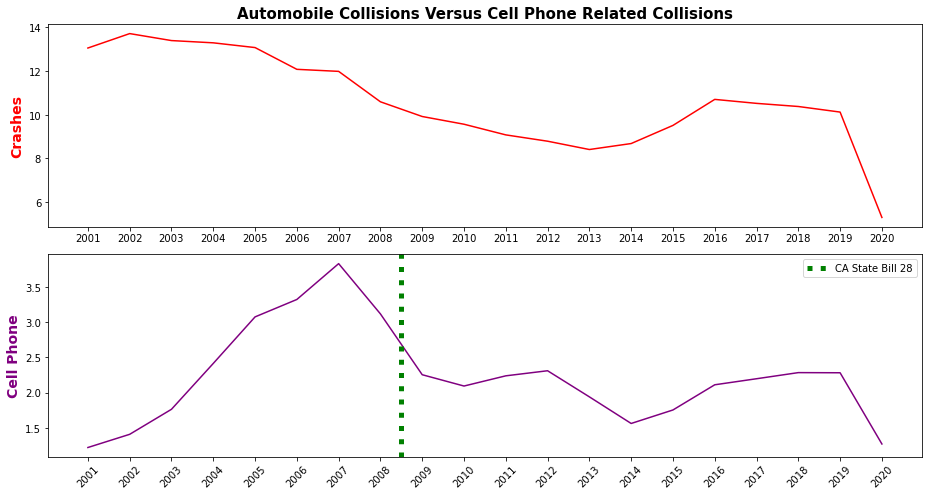

In [62]:
#Plot crashes on left side y axis compared to cell phone related crashes on right side y axis
# create figure and axis objects with subplots()

fig, axs = plt.subplots(2,1, figsize= (13,7))


x = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019','2020']
axs[0].set_title("Automobile Collisions Versus Cell Phone Related Collisions",fontweight="bold", fontsize = 15, color = "black")
axs[0].plot(x , car_crashes_per_year['per 1000 rate crashes'],color="red" )
axs[0].set_ylabel("Crashes", fontweight="bold", fontsize = 14, color="red")

x = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019','2020']

axs[1].plot(x, cell_df_per_year['total_cellphone_use'], color = 'purple')
axs[1].set_ylabel("Cell Phone", color="purple",fontsize=14, fontweight ='bold')

plt.xticks(rotation=45)

# only one line may be specified; full height
plt.axvline(x=7.5, color='g',ls=':', lw=5,label='CA State Bill 28')
plt.legend(bbox_to_anchor=(1.0, 1), loc='best')


plt.tight_layout()
#plt.savefig('collision_cellphoneuse.png')
plt.show();





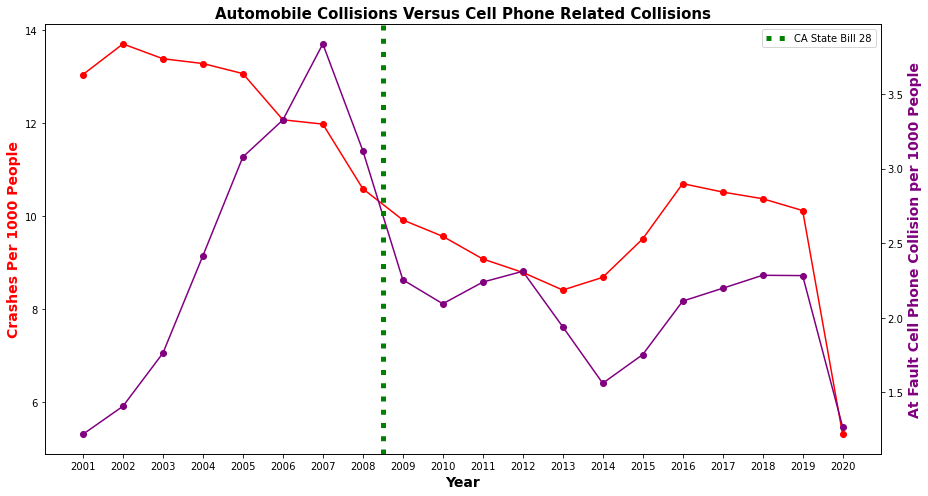

In [27]:
#Plot crashes on left side y axis compared to cell phone related crashes on right side y axis
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (13,7))


#define x = year
x = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019','2020']
# make a plot
ax.plot(x, car_crashes_per_year['per 1000 rate crashes'], color="red", marker="o")


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(x, cell_df_per_year['total_cellphone_use'] ,color="purple",marker="o")
ax2.set_ylabel("At Fault Cell Phone Collision per 1000 People",color="purple",fontsize=14, fontweight ='bold') # add responsible for collision


# only one line may be specified; full height
plt.axvline(x=7.5, color='g',ls=':', lw=5,label='CA State Bill 28')
plt.legend(bbox_to_anchor=(1.0, 1), loc='best')


ax.set_xlabel('Year', fontweight="bold", fontsize = 14)
ax.set_ylabel('Crashes Per 1000 People', fontweight="bold", fontsize = 14, color="red")

plt.title("Automobile Collisions Versus Cell Phone Related Collisions",fontweight="bold", fontsize = 15, color = "black")

#reword title axis

#ax2.grid(None)

plt.tight_layout()

plt.show()

Mention high adoption of cell phone use in 2001- 2006


In [28]:
#Query where cellphone was not in  use
query = '''SELECT cellphone_use, CASE_ID FROM parties
           WHERE at_fault
           AND cellphone_use IS 'C'
           OR cellphone_use IS 'D'
           OR cellphone_use IS 3
           GROUP BY CASE_ID
    '''

no_cell= pd.read_sql_query(query, con)


In [29]:
#merge collisions and parties table
no_cell_df =  data_merge.merge(no_cell, left_on='case_id', right_on= 'case_id')

no_cell_df.groupby(['cellphone_use'])
no_cell_df


,collision_date,case_id,cellphone_use
0,2020-03-14,0081715,3
1,2008-01-07,3503560,3
2,2008-01-07,3511306,3
3,2008-01-03,3511318,3
4,2008-01-08,3511326,3
...,...,...,...
6157809,2016-03-23,8054130,3
6157810,2016-05-11,8071228,3
6157811,2016-08-15,8112338,3
6157812,2016-08-18,8121975,3


In [30]:
#Find sum of cell phone collisions for Fisher test
start_date = "2001-01-01"
end_date = "2008-06-30"

after_start_date = no_cell_df["collision_date"] >= start_date
before_end_date = no_cell_df["collision_date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = no_cell_df.loc[between_two_dates]
filtered_dates


,collision_date,case_id,cellphone_use
1,2008-01-07,3503560,3
2,2008-01-07,3511306,3
3,2008-01-03,3511318,3
4,2008-01-08,3511326,3
5,2008-01-11,3511354,3
...,...,...,...
6157605,2001-12-23,9870011223081511850,C
6157606,2001-12-24,9870011224092016011,D
6157607,2001-12-24,9870011224123011850,D
6157608,2001-12-26,9870011226102009803,D


                          before bill (7.5yr)~8959peryr             after bill(12.5)~7868. 13% less crashes cell relatd crashes
    no_cell_crash          2251763                                       3906051
    cell_use_crash         67195                                            98351
      

In [31]:
#Fisher test: why did I use fisher test, null and alternate

oddsratio, pvalue =stats.fisher_exact([[ 2251763  , 3906051], [67195 , 98351]])

print(pvalue)


5.661595746785089e-243


In [32]:
#correlation calculation - not a unit relationship
cellphone_corr = stats.pearsonr(car_crashes_per_year['per 1000 rate crashes'], cell_df_per_year['total_cellphone_use'])

killedvictim_corr = stats.pearsonr(cell_df_per_year['total_cellphone_use'], killed_victims['total_killed_victims'])

print(cellphone_corr)

print(killedvictim_corr)

#-weak + corre


(0.2709236557076214, 0.24794226605057346)
(0.061016748060924095, 0.7983040442798608)


R value is .27 and this indicates a rather weak correlation between car collisions and cell phone use. But R value for victims killed and cell phone use is only .06 which shows a very low to insignificant correlation


The National Safety Council reports that cell phone use while driving leads to 1.6 million crashes each year.
Nearly 390,000 injuries occur each year from accidents caused by texting while driving.
1 out of every 4 car accidents in the United States is caused by texting and driving.
Texting while driving is 6x more likely to cause an accident than driving drunk.
https://www.edgarsnyder.com/car-accident/cause-of-accident/cell-phone/cell-phone-statistics.html#:~:text=The%20National%20Safety%20Council%20reports,caused%20by%20texting%20and%20driving.


In [33]:
#Query where alcohol was involved in automobile collisions
query = '''SELECT Collision_Date FROM collisions
            WHERE Collision_Date IS NOT NULL
            AND alcohol_involved IS 1
            AND Bicycle_Collision IS NOT 1
            AND Motorcycle_Collision IS NOT 1
            AND Pedestrian_Collision IS NOT 1
            AND Truck_Collision IS NOT 1
    '''

alcohol_involved = pd.read_sql_query(query, con)



In [34]:
#convert to year
alcohol_involved['num_yr'] = pd.DatetimeIndex(alcohol_involved['collision_date']).year
alcohol_involved = alcohol_involved.groupby('num_yr').count()
alcohol_involved
#alc involved where no one killed 806,004, alc involved where people killed = 11,311


,collision_date
num_yr,
2001,42704
2002,44422
2003,44337
2004,45460
2005,45991
2006,45777
2007,47997
2008,44904
2009,41158


In [35]:
#normalize by population
alcohol_involved['ca_pop'] = [34.49, 34.49, 34.88, 35.25, 35.56, 35.98, 36.23, 36.58,36.96,37.32,37.64, 37.95, 38.26, 38.6,38.92, 39.17,39.36, 39.46, 39.51, 39.78]
alcohol_involved['alc_use'] = alcohol_involved['collision_date']/alcohol_involved['ca_pop']
alcohol_involved['alc_use']=alcohol_involved['alc_use']  /100000 *(1000)


In [36]:
killed_victims['killed_per_alc_use'] = killed_victims['total_killed_victims']/alcohol_involved['alc_use']

killed_victims['killed_per_cell_use'] = killed_victims['total_killed_victims']/cell_df_per_year['total_cellphone_use']


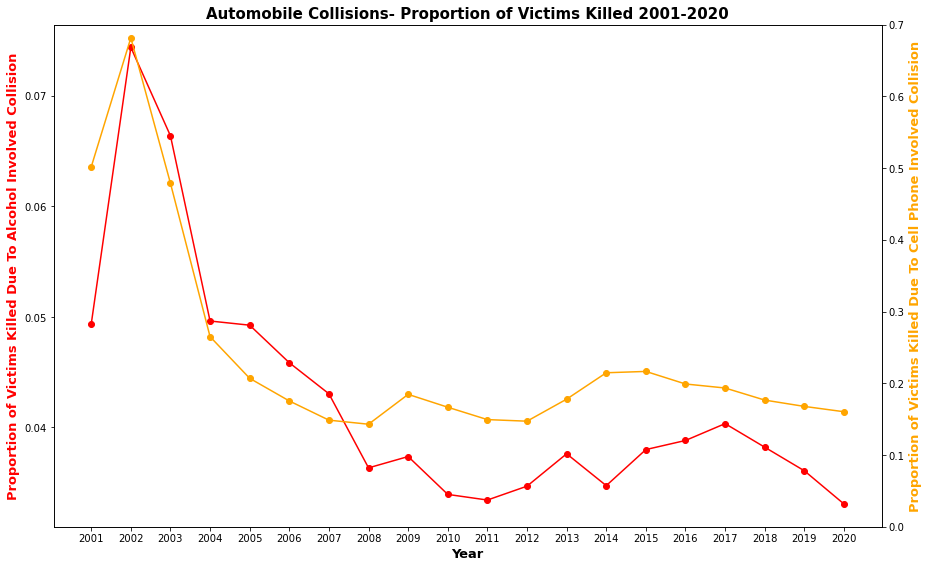

In [37]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (13, 8))

#define x = year
x = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019','2020']
# make a plot
ax.plot(x, killed_victims['killed_per_alc_use'] , color="red", marker="o")

# set x-axis label
ax.set_xlabel("Year",fontsize=13, fontweight="bold")
# set y-axis label

ax.set_ylabel('Proportion of Victims Killed Due To Alcohol Involved Collision', color="red",fontsize=13, fontweight="bold")
ax2.set_ylim(0, .07)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(x, killed_victims['killed_per_cell_use'] ,color="orange",marker="o")
ax2.set_ylabel("Proportion of Victims Killed Due To Cell Phone Involved Collision",color="orange",fontsize=13, fontweight="bold")
ax2.set_ylim(0, .7)

plt.title("Automobile Collisions- Proportion of Victims Killed 2001-2020",fontweight="bold",fontsize=15)
#ax2.grid(None)

plt.tight_layout()

plt.show()
#fix axes labels - alco use per 1k -- vehc collisions while under the influence

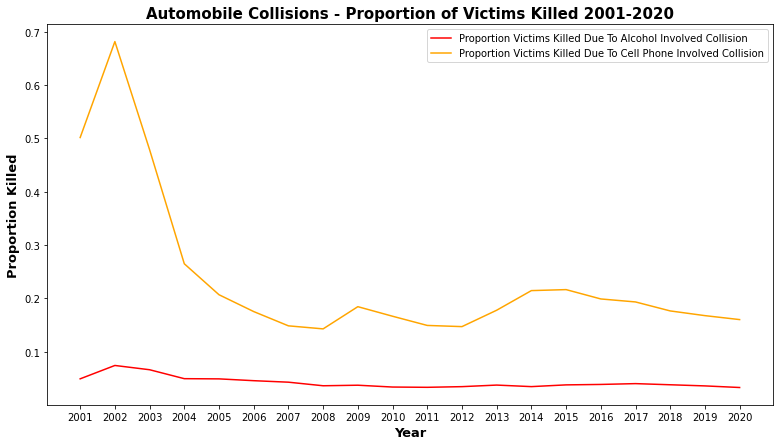

In [38]:
plt.figure(figsize=(13,7))
x = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019','2020']
plt.plot(x, killed_victims['killed_per_alc_use'] , color='red', label = "Proportion Victims Killed Due To Alcohol Involved Collision")
plt.plot(x, killed_victims['killed_per_cell_use'], color='orange', label = "Proportion Victims Killed Due To Cell Phone Involved Collision")

plt.xlabel("Year", fontsize=13, fontweight="bold")
plt.ylabel("Proportion Killed", fontsize=13, fontweight="bold")
plt.title("Automobile Collisions - Proportion of Victims Killed 2001-2020",fontweight="bold",fontsize=15)
#proportion = car crash victims/ people drinking and driving involved in collision
plt.legend()

#Re-ran the queries with below conditions to get those #s:

                alcohol_use  cell_phone_use
      killed        11311     567
      notkilled     806004    25066
      
    -total killed: 33650
    
Fisher Test: Null: drivers involved in a car collision while drinking alcohol and drivers using cell phone use while drinking should have equal proportions of victims being killed during a collision.
Alt: The probabilities of thse two drivers are unevenly distributed

Proportion is not evenly ditributed given p value from fisher test:

proportion of victims killed is higher among those involved in accident where driver was drinking alcohol than where
driver was using cell phone and was involved in an accident


In [39]:
#Fisher test

oddsratio, pvalue =stats.fisher_exact([[11311 , 567], [806004 , 25066]])

print(pvalue)
#stats.fisher_exact(table, alternative='two-sided')

#The probability that we would observe this or an even more imbalanced ratio by chance is about 9.35e-25. With a 5%
#signficance level, we can conclude that our observed imbalance is statistically significant
#-The number of killed prefer the alcohol use while not killed prefer the celluse

-sql python assignment and learn module automate code


SyntaxError: invalid syntax (<ipython-input-39-2056f22fed22>, line 12)

In [ ]:
query = '''SELECT killed_victims, CASE_ID, Collision_Date FROM collisions
           WHERE killed_victims IS 1 AND
           Collision_Date IS NOT NULL
          
            AND Bicycle_Collision IS NOT 1
            AND Motorcycle_Collision IS NOT 1
            AND Pedestrian_Collision IS NOT 1
            AND Truck_Collision IS NOT 1
            GROUP BY CASE_ID
    '''

alc_killed= pd.read_sql_query(query, con)


In [ ]:
query = '''SELECT cellphone_use, CASE_ID FROM parties
           WHERE at_fault
           AND cellphone_use IS 'B'
           OR cellphone_use IS 1
           OR cellphone_use IS 2
           GROUP BY CASE_ID
    '''

cell_killed= pd.read_sql_query(query, con)



In [ ]:
merged =  alc_killed.merge(cell_killed, left_on='case_id', right_on= 'case_id')
merged


In [ ]:
merged['num_yr'] = pd.DatetimeIndex(merged['collision_date']).year
merged = merged.groupby('num_yr').count()
merged


In [ ]:
query =( '''SELECT party_age, CASE_ID,
    SUM(CASE WHEN party_sex="male" THEN 0 ELSE 1 END) AS female,
    SUM(CASE WHEN party_sex="male" THEN 1 ELSE 0 END) AS male
    FROM parties 
    WHERE party_sobriety IN ('B', 'D', 'C' ) AND at_fault AND party_sex IN ('male', 'female')
    GROUP BY party_age''')
alcohol_use = pd.read_sql_query(query, con)
alcohol_use.dropna(inplace=True)


A - Had Not Been Drinking
B - Had Been Drinking, Under Influence
C - Had Been Drinking, Not Under Influence
D - Had Been Drinking, Impairment Unknown
G - Impairment Unknown
H - Not Applicable


In [ ]:
age = alcohol_use[alcohol_use['party_age']> 12]
age


In [ ]:
plt.figure(figsize=(12,5))
plt.plot(age["party_age"], age["male"], color='blue', label = "male")
plt.plot(age["party_age"], age["female"],color='red', label = "female")

plt.xlabel("Age", fontsize=13, fontweight="bold")
plt.ylabel("Number Of Crashes", fontsize=13, fontweight="bold")
#plt.xlim([0, 120])

plt.title("At Fault Alcohol Related Automobile Collisions",fontweight="bold", fontsize=15)

plt.legend()


In [ ]:
query =( '''SELECT party_age, CASE_ID, party_number_killed,
    SUM(CASE WHEN party_sex="male" THEN 0 ELSE 1 END) AS female,
    SUM(CASE WHEN party_sex="male" THEN 1 ELSE 0 END) AS male
    FROM parties 
    WHERE party_sobriety IN ('B', 'D', 'C' ) AND at_fault AND party_sex IN ('male', 'female')
    GROUP BY party_age''')
nalc = pd.read_sql_query(query, con)
nalc.dropna(inplace=True)


In [ ]:
nalc =nalc.loc[(nalc['party_age']>37) & (nalc['party_age'] < 49)]
nalc.sum()


In [ ]:
M             age 18-28          age 38-48
     alc_coll  2.569380e+05      1.017930e+05
     no alc   1.273632e+06       6.178990e+05
      

Fisher Test: 
Null: Alcohol related collisions for age group of males b/t 18-28 and age group of males b/t 38-48 should have equal proportions. Alt: The probabilities of thse two age groups are unevenly distributed

Proportion is not evenly ditributed given p value from fisher test:

proportion of males aged 18-28 being involved in a collision given they are drinking is higher than the older age group.



In [ ]:
#Fisher test

oddsratio, pvalue =stats.fisher_exact([[2.569380e+05, 1.017930e+05], [1.273632e+06 , 6.178990e+05]])

print(pvalue)


In [ ]:
FM          age 18-28                age 38-48
     alc_coll  7.190800e+04         3.291400e+04
     no alc  8.205590e+05            3.765290e+05
      

Fisher Test: 
Null: Alcohol related collisions for age group of females b/t 18-28 and age group of females b/t 38-48 should have
    equal proportions. Alt: The probabilities of thse two age groups are unevenly distributed

Proportion is evenly ditributed given p value from fisher test:

proportion of females aged 18-28 being involved in a collision given they are drinking is similar to the older age group.

In [ ]:
#Fisher test

oddsratio, pvalue =stats.fisher_exact([[7.190800e+04, 3.291400e+04], [8.205590e+05   ,   3.765290e+05]])

print(pvalue)


Sources:
https://www.kaggle.com/alexgude/california-traffic-collision-data-from-switrs
https://www.cdc.gov/injury/features/global-road-safety/index.html)
https://www.edgarsnyder.com/car-accident/cause-of-accident/cell-phone/cell-phone-statistics.html#:~:text=The%20National%20Safety%20Council%20reports,caused%20by%20texting%20and%20driving
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4001674/ C   
https://www.statista.com/statistics/206097/resident-population-in-california/
https://fred.stlouisfed.org/series/CAUR